In [20]:
version='v1'
model_save='/media/thor/hdd4/NBSoft/nadim/Goldstone/model_save'
print(model_save)

/media/thor/hdd4/NBSoft/nadim/Goldstone/model_save


In [21]:
import random
import numpy as np
import pandas as pd
import torch
def torch_fix_seed(seed=99):
    # Python random
    random.seed(seed)

    # Numpy
    np.random.seed(seed)
    
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed(99)

### Pre processsing

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
df = pd.read_csv('/media/thor/hdd4/NBSoft/nadim/Goldstone/preditive_model/Grid_search_Neural_Network/Dataset/diabetes.csv')

In [24]:
df.shape

(768, 9)

In [25]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.1)

In [26]:
print(df_train.shape, df_test.shape, df_val.shape)

(621, 9) (77, 9) (70, 9)


In [27]:
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
463,5,88,78,30,0,27.6,0.258,37,0
760,2,88,58,26,16,28.4,0.766,22,0
621,2,92,76,20,0,24.2,1.698,28,0
497,2,81,72,15,76,30.1,0.547,25,0
34,10,122,78,31,0,27.6,0.512,45,0


In [28]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 584 to 178
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               70 non-null     int64  
 1   Glucose                   70 non-null     int64  
 2   BloodPressure             70 non-null     int64  
 3   SkinThickness             70 non-null     int64  
 4   Insulin                   70 non-null     int64  
 5   BMI                       70 non-null     float64
 6   DiabetesPedigreeFunction  70 non-null     float64
 7   Age                       70 non-null     int64  
 8   Outcome                   70 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 5.5 KB


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 463 to 265
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               621 non-null    int64  
 1   Glucose                   621 non-null    int64  
 2   BloodPressure             621 non-null    int64  
 3   SkinThickness             621 non-null    int64  
 4   Insulin                   621 non-null    int64  
 5   BMI                       621 non-null    float64
 6   DiabetesPedigreeFunction  621 non-null    float64
 7   Age                       621 non-null    int64  
 8   Outcome                   621 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.5 KB


In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 129 to 516
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               77 non-null     int64  
 1   Glucose                   77 non-null     int64  
 2   BloodPressure             77 non-null     int64  
 3   SkinThickness             77 non-null     int64  
 4   Insulin                   77 non-null     int64  
 5   BMI                       77 non-null     float64
 6   DiabetesPedigreeFunction  77 non-null     float64
 7   Age                       77 non-null     int64  
 8   Outcome                   77 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 6.0 KB


In [31]:
df_test.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [32]:
columns_to_select = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
y_train = df_train[['Outcome']].astype('float32')
X_train = df_train[columns_to_select].astype('float32')

y_test = df_test[['Outcome']].astype('float32')
X_test = df_test[columns_to_select].astype('float32')

y_val = df_val[['Outcome']].astype('float32')
X_val = df_val[columns_to_select].astype('float32')

### Normalizing dataset

In [33]:
from sklearn.preprocessing import StandardScaler
import pickle


scaler = StandardScaler()
scaler.fit(X_train)

X_train[columns_to_select] = scaler.transform(X_train[columns_to_select])
X_test[columns_to_select] = scaler.transform(X_test[columns_to_select])
X_val[columns_to_select] = scaler.transform(X_val[columns_to_select])

with open(model_save+'/'+version+'.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open(model_save+'/'+version+'.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

In [35]:
! pip install skorch

In [36]:
from sklearn.model_selection import PredefinedSplit
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

split_index = [-1]*len(X_train) + [0]*len(X_val)

pds = PredefinedSplit(test_fold = split_index)

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV


# Define PyTorch Classification model
class SimpleClassificationModel(nn.Module):
    def __init__(self, init_mode='he_uniform', activation = F.relu,dropout_rate=0.5, neuron_number = 10, **kwargs):
        super(SimpleClassificationModel, self).__init__()
        self.init_mode = init_mode
        self.neuron_number = neuron_number
        self.fc1 = nn.Linear(8, self.neuron_number)
        self.fc2 = nn.Linear(self.neuron_number, 1)
        self.dropout_rate = nn.Dropout(p=dropout_rate)

        self.activation = activation
        self._initialize_weights(self.init_mode)

    def _initialize_weights(self, init_mode):
        init = init_mode.lower()

        init_fn = {
            'he_uniform': nn.init.kaiming_uniform_,
            'he_normal': nn.init.kaiming_normal_,
            'glorot_uniform': nn.init.xavier_uniform_,
            'glorot_normal': nn.init.xavier_normal_,
        }[init]

        init_fn(self.fc1.weight)
        init_fn(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)


    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout_rate(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [38]:
# Define skorch wrapper
model = NeuralNetClassifier(
    module=SimpleClassificationModel,
    criterion=nn.BCELoss,
    iterator_train__shuffle=True,
    verbose=0,
    device = device
)

# Grid search over max_epochs and batch_size
param_grid = {
    'optimizer': [torch.optim.SGD,  torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.Adam, torch.optim.Adamax],

    # 'max_epochs': [50, 100, 500, 1000, 3000],
    'max_epochs': [100, 500, 1000, ],
    'batch_size': [ 20, 40, 80, 100],
    
    # 'optimizer__lr': [0.001, 0.01, 0.1, 0.2, 0.3],
    'optimizer__lr': [0.001, 0.01, 0.1],

    
    'module__init_mode': ['he_uniform'],
    # 'module__init_mode': ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'],

    # 'module__activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    'module__activation': [F.relu],
    
    'module__dropout_rate': [0.2, 0.3, 0.5],
    # 'module__dropout_rate': [0.2],

    'module__self.neuron_number': [5, 10 , 20]
    # 'module__self.neuron_number': [12],

}


grid = GridSearchCV(estimator= model, param_grid=param_grid, n_jobs=-1, cv= pds, scoring='neg_log_loss')
grid_result = grid.fit(X, y)


In [39]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, std, param in zip(grid_result.cv_results_['mean_test_score'],
                            grid_result.cv_results_['std_test_score'],
                            grid_result.cv_results_['params']):
    print("%f (%f) with: %r" % (mean, std, param))


Best: -0.346582 using {'batch_size': 20, 'max_epochs': 1000, 'module__activation': <function relu at 0x7ff8a97f64c0>, 'module__dropout_rate': 0.2, 'module__init_mode': 'he_uniform', 'module__self.neuron_number': 20, 'optimizer': <class 'torch.optim.adamax.Adamax'>, 'optimizer__lr': 0.01}
-0.653939 (0.000000) with: {'batch_size': 20, 'max_epochs': 100, 'module__activation': <function relu at 0x7ff8a97f64c0>, 'module__dropout_rate': 0.2, 'module__init_mode': 'he_uniform', 'module__self.neuron_number': 5, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
-0.444075 (0.000000) with: {'batch_size': 20, 'max_epochs': 100, 'module__activation': <function relu at 0x7ff8a97f64c0>, 'module__dropout_rate': 0.2, 'module__init_mode': 'he_uniform', 'module__self.neuron_number': 5, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.01}
-0.403226 (0.000000) with: {'batch_size': 20, 'max_epochs': 100, 'module__activation': <function relu at 0x7ff8a97f64c0>, 'module__dropout

In [40]:
with open(model_save+ '/'+version+'best_model.pkl', 'wb') as f:
    pickle.dump(grid,f)

with open(model_save+ '/'+version+'best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc

In [74]:
def calculate_prediction(model, X):
    return torch.tensor(model.predict(X))

def calculate_prediction_proba(model, X):
    return torch.tensor(model.predict_proba(X))

def extract_all_result(actual,prediction, type):
    tn, fp, fn, tp = confusion_matrix(actual, prediction).ravel()
    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    accuracy = accuracy_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    specificity = tn / (tn + fp)

    print(type," result")
    print(f"Acc:{accuracy:.2f} Pre:{precision:.2f}")
    print(f"Rec:{recall:.2f} Spe:{specificity:.2f}")
    print(f"f1:{f1:.2f}")

    cm = ConfusionMatrixDisplay(confusion_matrix(actual, prediction))
    cm.plot(cmap='Blues')
    plt.title(type+ " confusion matrix")
    plt.show()
    return [round(accuracy,2), round(precision,2), round(recall,2), round(specificity,2), round(f1,2)]

In [43]:
y_train_pred = calculate_prediction(loaded_model.best_estimator_, X_train.astype('float32').values)
y_test_pred = calculate_prediction(loaded_model.best_estimator_, X_test.astype('float32').values)
y_val_pred = calculate_prediction(loaded_model.best_estimator_, X_val.astype('float32').values)


y_train_proba = calculate_prediction_proba(loaded_model.best_estimator_, X_train.astype('float32').values)
y_test_proba = calculate_prediction_proba(loaded_model.best_estimator_, X_test.astype('float32').values)
y_val_proba = calculate_prediction_proba(loaded_model.best_estimator_, X_val.astype('float32').values)

Train  result
Acc:0.82 Pre:0.81
Rec:0.64 Spe:0.92
f1:0.72


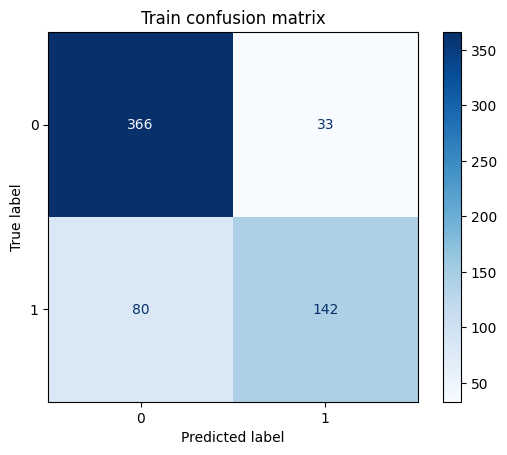

In [75]:
train_res = extract_all_result(y_train, y_train_pred, "Train")

Test  result
Acc:0.73 Pre:0.59
Rec:0.52 Spe:0.83
f1:0.55


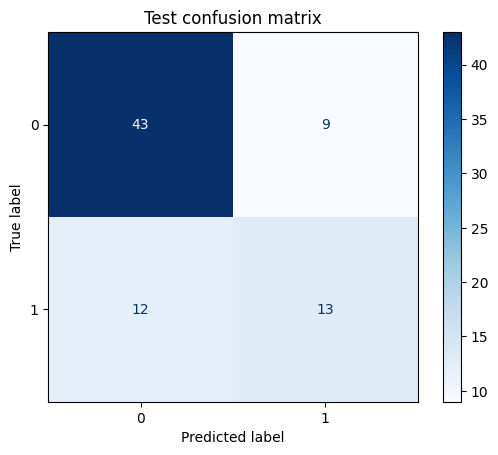

In [76]:
test_res = extract_all_result(y_test, y_test_pred, "Test")

Val  result
Acc:0.86 Pre:0.76
Rec:0.76 Spe:0.90
f1:0.76


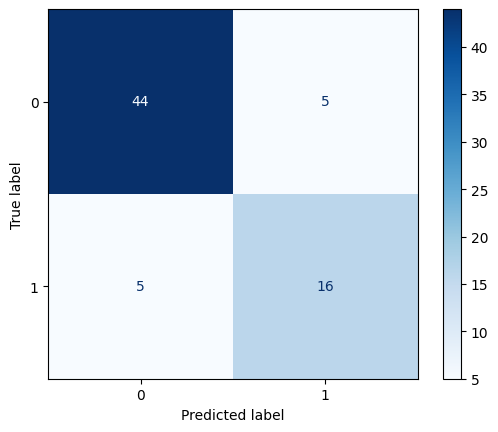

In [46]:
val_res = extract_all_result(y_val, y_val_pred, "Val")

In [47]:
def calculate_pr_curve(actucal, prediction):
    precision, recall, _ = precision_recall_curve(actucal, prediction[:,1])
    average_precision  =  average_precision_score(actucal, prediction[:,1])

    auc_pr = auc(recall, precision)
    print(round(auc_pr, 3), round(average_precision, 3))
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step = 'post', alpha = 0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    

    fpr, tpr, thresholds = roc_curve(actucal, prediction[:,1])
    roc_auc = auc(fpr, tpr)
    print("roc_auc",round(roc_auc,3))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate Youden's J statistic
    Youdens_J = tpr - fpr
    # Find the optimal threshold based on Youden's J statistic
    optimal_threshold = thresholds[np.argmax(Youdens_J)]
  

    return round(auc_pr, 3), round(roc_auc,3), optimal_threshold

0.798 0.801


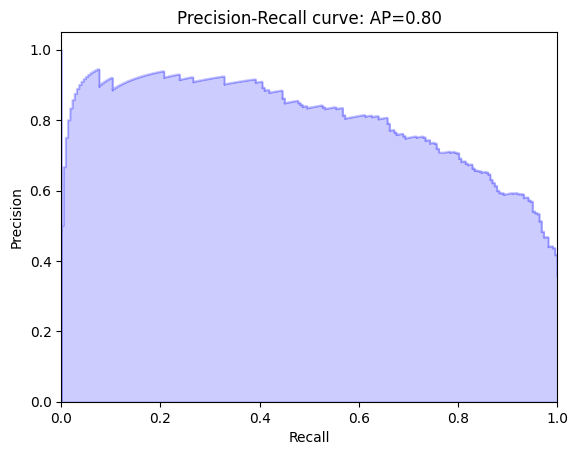

roc_auc 0.886


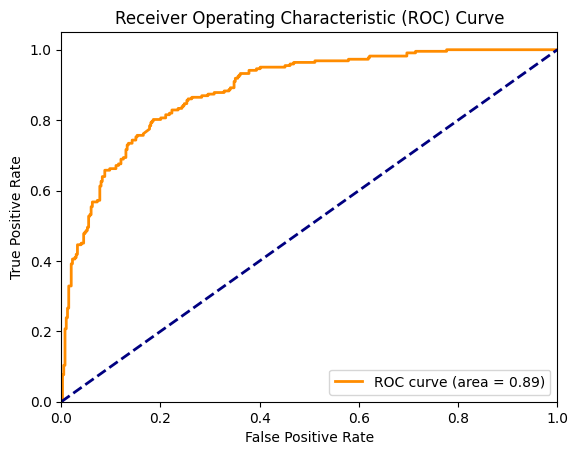

In [48]:
pr_train, roc_train, train_optimal_threshold = calculate_pr_curve (y_train, y_train_proba)

y_train_pred_optimal = (y_train_proba[:,1] > train_optimal_threshold).to(torch.int)
y_test_pred_optimal = (y_test_proba[:,1] > train_optimal_threshold).to(torch.int)
y_val_pred_optimal = (y_val_proba[:,1] > train_optimal_threshold).to(torch.int)

Train  result
Acc:0.81 Pre:0.71
Rec:0.80 Spe:0.81
f1:0.75


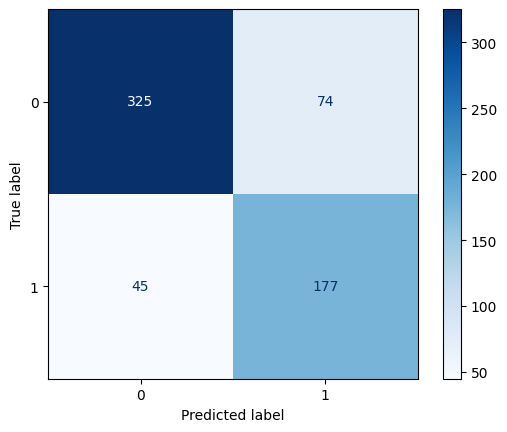

In [49]:
train_res_optimal = extract_all_result(y_train, y_train_pred_optimal, "Train")

Test  result
Acc:0.69 Pre:0.52
Rec:0.64 Spe:0.71
f1:0.57


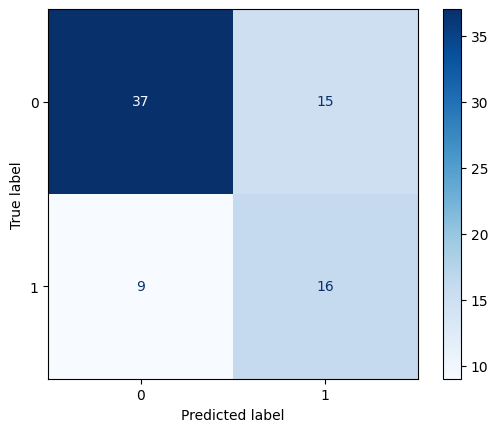

In [50]:
test_res_optimal = extract_all_result(y_test, y_test_pred_optimal, "Test")

Val  result
Acc:0.84 Pre:0.71
Rec:0.81 Spe:0.86
f1:0.76


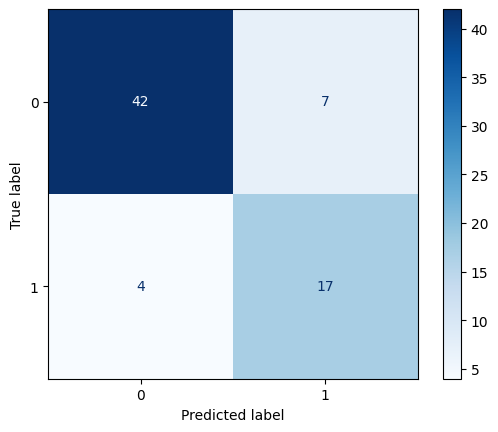

In [51]:
val_res_optimal = extract_all_result(y_val, y_val_pred_optimal, "Val")

0.556 0.578


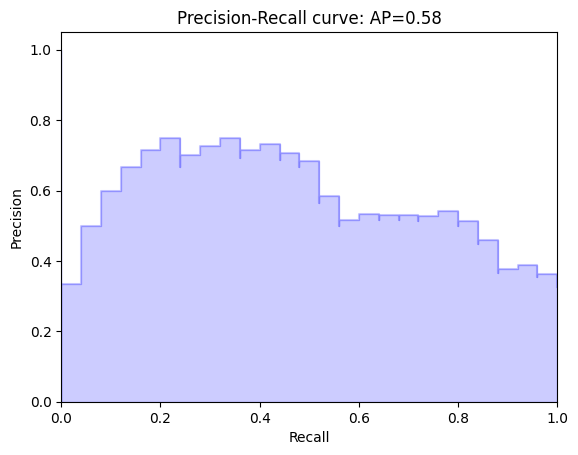

roc_auc 0.762


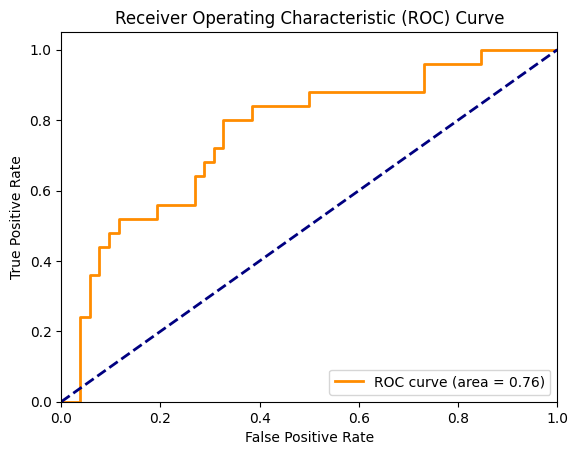

In [52]:
pr_test, roc_test, test_optimal_threshold = calculate_pr_curve (y_test, y_test_proba)

In [53]:
train_res.extend([pr_train, roc_train])
train_res.extend(test_res)
train_res.extend([pr_test, roc_test])

In [54]:
print(0.5, *train_res)
print(round(train_optimal_threshold,2), *train_res_optimal, pr_train, pr_test, *test_res_optimal, pr_test, roc_test)

0.5 0.82 0.81 0.64 0.92 0.72 0.798 0.886 0.73 0.59 0.52 0.83 0.55 0.556 0.762
0.38 0.81 0.71 0.8 0.81 0.75 0.798 0.556 0.69 0.52 0.64 0.71 0.57 0.556 0.762


In [55]:
!pip install shap
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [56]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
463,0.374947,-1.028250,0.472849,0.568321,-0.695045,-0.553103,-0.643838,0.301919
760,-0.532230,-1.028250,-0.553503,0.320522,-0.556551,-0.452273,0.862669,-0.959802
621,-0.532230,-0.903675,0.370214,-0.051176,-0.695045,-0.981629,3.626577,-0.455113
497,-0.532230,-1.246258,0.164943,-0.360924,-0.037202,-0.238009,0.213210,-0.707458
34,1.886909,0.030642,0.472849,0.630270,-0.695045,-0.553103,0.109416,0.974837
...,...,...,...,...,...,...,...,...
376,-1.137015,-0.716811,0.678119,-0.360924,0.032045,-0.855592,-0.522250,-0.959802
88,3.398872,0.466657,0.062308,0.692220,0.257096,0.644251,-0.955223,0.806607
598,-0.834623,1.618982,0.267579,-1.290169,-0.695045,0.606440,-1.147985,0.386034
501,-0.229838,-1.152826,0.164943,0.692220,-0.695045,0.656855,-0.617148,-0.455113


In [57]:
explainer = shap.KernelExplainer(loaded_model.best_estimator_.predict_proba, shap.kmeans(X_train.astype(np.float32), 50), nsamples = 2000)

if isinstance(X_train, np.ndarray):  
    X_train_df = pd.DataFrame(X_train, columns=columns_to_select)
else:
    X_train_df = X_train

# shap_values = explainer.shap_values(X_train_df.astype(np.float32))

In [58]:
X_train_df.iloc[1].astype(np.float32)

Pregnancies                -0.532230
Glucose                    -1.028250
BloodPressure              -0.553503
SkinThickness               0.320522
Insulin                    -0.556551
BMI                        -0.452273
DiabetesPedigreeFunction    0.862669
Age                        -0.959802
Name: 760, dtype: float32

In [59]:
# Get SHAP values for all samples
shap_values_global = explainer.shap_values(X_train_df.astype(np.float32))

# shap_values_global = np.mean(np.abs(shap_values_global), axis=0)  # Mean SHAP importance

explanation = shap.Explanation(
    values=shap_values_global,  
    base_values=explainer.expected_value,  
    data=X_train_df.astype(np.float32),
    feature_names=columns_to_select
)

100%|██████████| 621/621 [03:39<00:00,  2.83it/s]


In [62]:
np.array(explanation.values).shape

(2, 621, 8)

In [66]:
preds = loaded_model.best_estimator_.predict(X_train_df.values.astype(np.float32))
new_shap = []
for i, pred in enumerate(preds):
    # print(i, pred.item())
    # print(explanation.values[i][:,int(pred)].shape, pred)
    new_shap.append(explanation.values[pred.item()][i])

In [67]:
np.array(new_shap).shape

(621, 8)

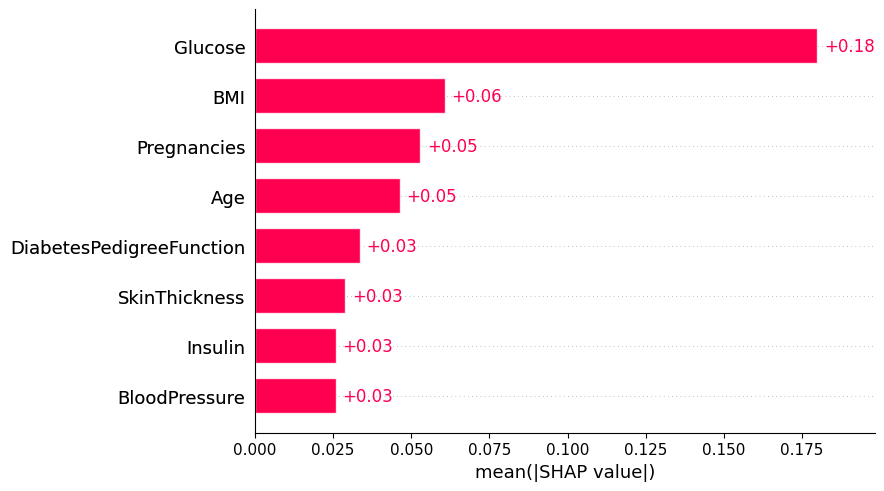

In [68]:
explanation.values = np.array(new_shap).squeeze()
shap.plots.bar(explanation, max_display=19)

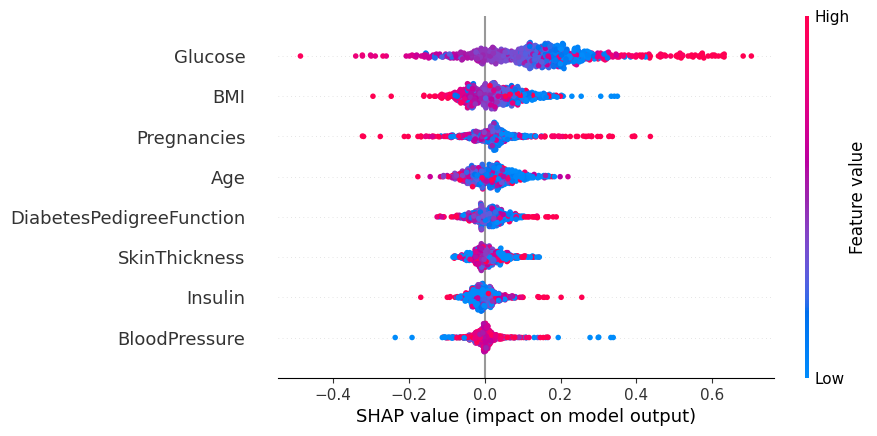

In [69]:
shap.plots.beeswarm(explanation, max_display=20)